In [1]:
import numpy as np
import dms_estimator as dmse
from matplotlib import pyplot as plt

np.set_printoptions(linewidth=100, suppress=True, precision=2, floatmode='fixed')
%matplotlib inline

## Plan vs Actual

**Plan**: One week per Milestone.

**Actual**:
- Week 1: 
    - Environment
    - Papers
    - Code framework
    - Start `_build_cnlls` and `_solve_ipopt`
- Week 2:
    - Start `interface.py`
    - Start `_solve_gn`
- Week 3: 
    - Gauss-Newton sometimes does not converge, add line search
    - Start `demo.ipynb`
- Week 4: Realized that shooting can be **parallel** and $H$ is **sparse**
    - Refactored `_build_cnlls` 
    - Add Schur complement in `_solve_gn`

## Some demo

###  Effectiveness of Multiple Shooting

Notorious test in §6 of [[Bock07](https://onlinelibrary.wiley.com/doi/pdf/10.1002/gamm.200790024?casa_token=1vkAqyG6JuwAAAAA%3AGwUN3aX6DOsp_FOatMYMQSZCDm27CWARJg90nhxYuZE_UCYlOsUxKim3UcWdrZjMtffexjzbiOGRJA)]

ODE:
$$
\dot{x}_1=x_2 \quad \dot{x}_2=\mu^2 x_1-\left(\mu^2+p^2\right) \sin p t \quad t \in[0,1]
$$

Initial values:
$$
x_1(0)=0 \quad x_2(0)=\pi
$$

The solution for the true parameter value $p=\pi$

$$
x_1(t)=\sin \pi t, \quad x_2(t)=\pi \cos \pi t
$$

In [2]:
cfg = dmse.ModelConfig(
        name="Notorious",
        build_integrator=dmse.notorious_problem,
        true_p=[np.pi],
        x0=np.array([0.0, np.pi, 0.0]),
        p_init=[1.0],
        state_labels=["x1", "x2", "t"],
)

Let's see what happens when we do numerical integration from $0$

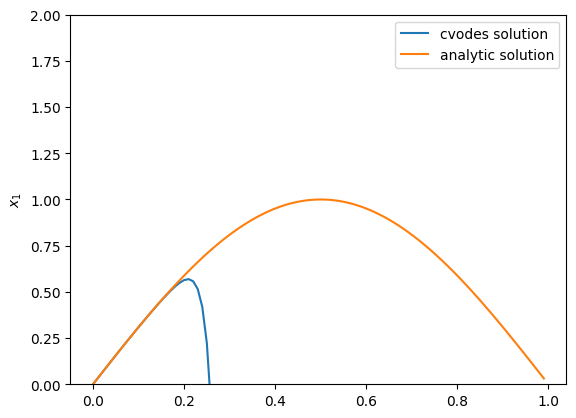

In [3]:
dt = 0.01
t_grid = np.arange(0.0, 1.0, dt)

integrator, ode, states, params = cfg.build_integrator(dt)
X_true, X_meas = dmse.generate_data(integrator, t_grid, cfg.x0, cfg.true_p, noise_std=0.0)
plt.plot(t_grid, X_true[:, 0], label='cvodes solution')

dt = 0.01
t_grid = np.arange(0.0, 1.0, dt)

X_true = np.array([
    np.sin(np.pi * t_grid), 
    np.pi * np.cos(np.pi * t_grid), 
    t_grid]
    ).T
rng = np.random.default_rng(42)
plt.plot(t_grid, X_true[:, 0], label='analytic solution')

plt.ylabel("$x_1$")
plt.ylim(0, 2)
plt.legend()
plt.show()

In [4]:
dt = 0.1
t_grid = np.arange(0.0, 1.0, dt)

X_true = np.array([
    np.sin(np.pi * t_grid), 
    np.pi * np.cos(np.pi * t_grid), 
    t_grid]
    ).T
rng = np.random.default_rng(42)
X_meas = X_true + 0.01 * rng.standard_normal(X_true.shape)

In [5]:
print("[Single Shooting]")
p_hat, s_hat = dmse.estimate(
    ode,
    states,
    params,
    t_grid,
    X_true,
    cfg.p_init,
    num_shooting=1,
    strategy="gn_fast",
)
print(f"Estimated:\n{p_hat}")
print(f"True:\n{np.array(cfg.true_p)}")

[Single Shooting]
[estimate] took 0.974508s
Estimated:
[0.20]
True:
[3.14]


Single shooting failed, try multiple shooting

In [6]:
p_hat, s_hat = dmse.estimate(
    ode,
    states,
    params,
    t_grid,
    X_meas,
    cfg.p_init,
    num_shooting=len(t_grid),
    strategy="gn",
)
print(f"Estimated:\n{p_hat}")
print(f"True:\n{np.array(cfg.true_p)}")

[gn] Converged at iter=8, f=1.704e-02
[estimate] took 0.082636s
Estimated:
[3.14]
True:
[3.14]


Even for **chaotic** dynamic system with **huge** noise!

[estimate] took 2.159209s


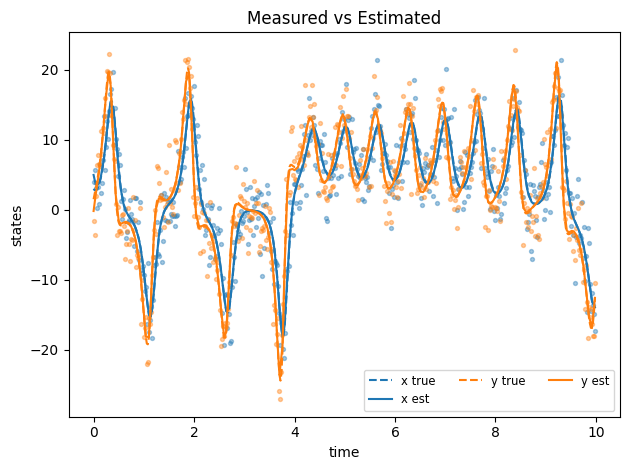

Estimated:
[10.64 27.83  2.68]
True:
[10.00 28.00  2.67]


In [7]:
cfg = dmse.ModelConfig(
        name="Lorenz",
        build_integrator=dmse.lorenz_problem,
        true_p=[10.0, 28.0, 8.0/3.0],
        x0=np.array([3.0, 1.5, 15.0]),
        p_init=[10.0] * 3,
        state_labels=["x", "y", "z"],
)

dt = 0.02
t_grid = np.arange(0.0, 10.0, dt)

integrator, ode, states, params = cfg.build_integrator(dt)
X_true, X_meas = dmse.generate_data(integrator, t_grid, cfg.x0, cfg.true_p, noise_std=3.0)

p_hat, s_hat = dmse.estimate(
    ode,
    states,
    params,
    t_grid,
    X_meas,
    cfg.p_init,
    num_shooting=200,
    strategy="gn_fast",
)
dmse.plot(t_grid, X_meas[:, :2], s_hat[:, :2], cfg.state_labels[:2], true=X_true[:, :2])
plt.show()
print(f"Estimated:\n{p_hat}")
print(f"True:\n{np.array(cfg.true_p)}")

### Solve the pyridine problem

In [8]:
cfg = dmse.ModelConfig(
        name="Pyridine",
        build_integrator=dmse.pyridine_problem,
        true_p=[1.81, 0.894, 29.4, 9.21, 0.058, 2.43, 0.0644, 5.55, 0.0201, 0.577, 2.15],
        x0=np.array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
        p_init=[1.0] * 11,
        state_labels=list("ABCDEFG"),
)

dt = 0.01
t_grid = np.arange(0.0, 5.0, dt)

integrator, ode, states, params = cfg.build_integrator(dt)
X_true, X_meas = dmse.generate_data(integrator, t_grid, cfg.x0, cfg.true_p)

[gn] no improvement at iter=4, stop.
[estimate] took 3.129793s


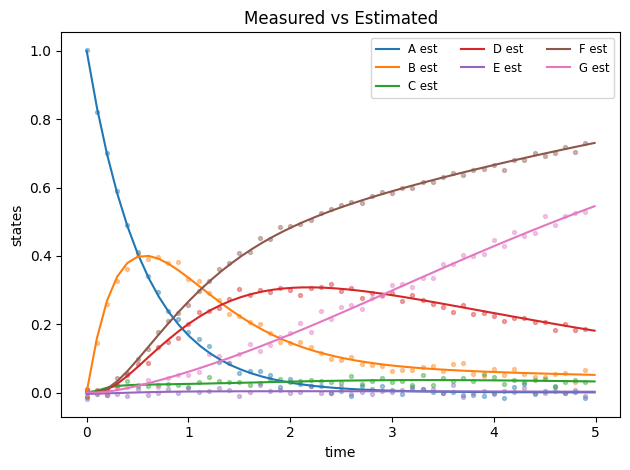

Estimated:
[ 1.80  0.90 31.29 10.74  0.05  2.80  0.07  2.55  0.02  0.60  8.86]
True:
[ 1.81  0.89 29.40  9.21  0.06  2.43  0.06  5.55  0.02  0.58  2.15]


In [9]:
p_hat, s_hat = dmse.estimate(
    ode,
    states,
    params,
    t_grid,
    X_meas,
    cfg.p_init,
    num_shooting=50,
    strategy="gn",
)
dmse.plot(t_grid, X_meas, s_hat, cfg.state_labels, show_every=10)
plt.show()
print(f"Estimated:\n{p_hat}")
print(f"True:\n{np.array(cfg.true_p)}")

$p_4$ is the coefficient of $C^2$ and $p_8, p_{11}$ if the coefficient of E

$C$ and $E$ are almost $0$, so larger error for these three.

## Method

TODO:
- shooting(parallel)
- GN
- Schur
- IG

## Benchmark Test

Time(s) consumed for different \#measurements, \#nodes and strategies(from `benchmark.py`)

All converge to acceptable results.

![talbe](./results/table.svg)

where
- **IP** is `ipopt`
- **IG** is `ipopt` with the given $H = J^\top J$ and `JIT`
- **GN** is the Gauß-Newton we implement with Schur complement.

**Findings**:
- **GN**: Gauß-Newton is optimal when the `#node` is small;
- **IPs**: The complexity of the `ipopt` does not increase significantly with the number of decision variables;
- **IG**: Outstanding in large-scale. Possible reasons:
    1. Using $J^\top J$ saves time in computing the Hessian and is good enough in least squares problems;
    2. `JIT` compiles the solver firstly thus saving time for each iteration.

**Problems**:
- I don't think the complexity of `qpoases` here should be $\mathcal{O}(n^2)$, but time-wise it's close to this.